In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Forecasting Australia's Population

In [50]:
df = pd.read_csv('global_economy.csv')

In [51]:
#df = df[df['Country'] == 'Australia']
df.drop(df.columns[0], axis=1, inplace=True)
df = df.dropna()
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [52]:
df.dtypes

Country               object
Code                  object
Year          datetime64[ns]
GDP                  float64
Growth               float64
CPI                  float64
Imports              float64
Exports              float64
Population           float64
dtype: object

In [53]:
df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
44,Afghanistan,AFG,2004-01-01,5.226779e+09,1.414118,63.523395,60.663923,30.921587,24118979.0
45,Afghanistan,AFG,2005-01-01,6.209138e+09,11.229715,71.582143,70.774646,28.448348,25070798.0
46,Afghanistan,AFG,2006-01-01,6.971286e+09,5.357403,76.438703,74.504401,25.317808,25893450.0
47,Afghanistan,AFG,2007-01-01,9.747880e+09,13.826320,83.074019,62.275757,19.117699,26616792.0
48,Afghanistan,AFG,2008-01-01,1.010923e+10,3.924984,105.021065,73.121366,26.948591,27294031.0


In [54]:
# Set 'Year' as the index
df.set_index('Year', inplace=True)

In [55]:
# Choose a specific country for forecasting
selected_country = 'Australia'

# Filter data for the selected country
country_df = df[df['Country'] == selected_country]

# Split data into training and test sets
train_size = int(0.8 * len(country_df))
train, test = country_df[:train_size], country_df[train_size:]

In [56]:
# Auto ARIMA Model
model = auto_arima(train['Population'], seasonal=True, m=12)  # m is the seasonal periodicity
model.fit(train['Population'])

# Forecast population
forecast_steps = len(test)
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Population'], forecast))
print(f'RMSE: {rmse}')

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\Rodrigo\AppD

RMSE: 864307.895210774


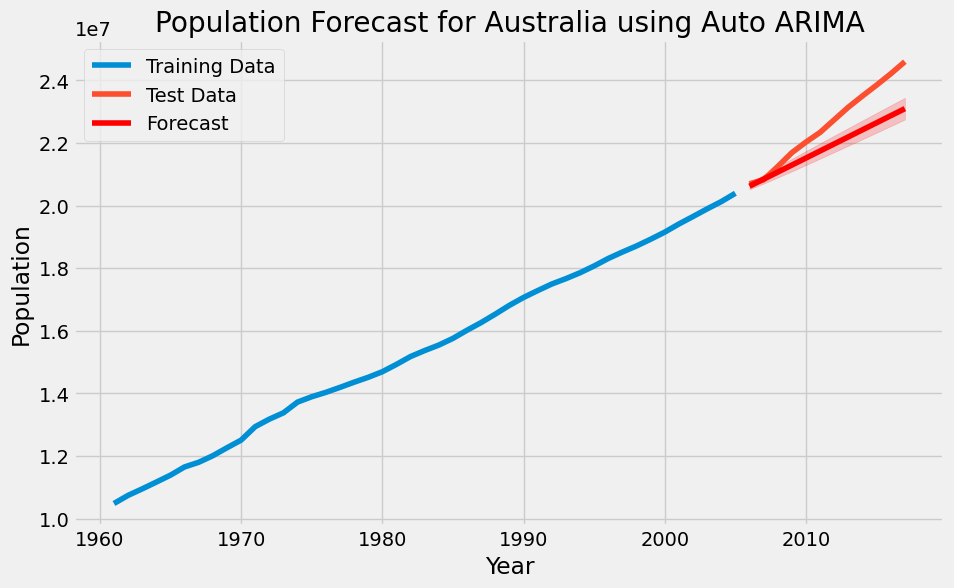

In [57]:
plt.style.use('fivethirtyeight')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Population'], label='Training Data')
plt.plot(test.index, test['Population'], label='Test Data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='r', alpha=0.2)
plt.title(f'Population Forecast for {selected_country} using Auto ARIMA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()

## Forecasting Australia's Brick Production

In [58]:
df =  pd.read_csv('aus_production.csv')

In [59]:
# Custom function to convert Quarter strings to the first day of the quarter
def quarter_to_datetime(quarter_str):
    year, quarter = quarter_str.split(' Q')
    quarter_start_month = (int(quarter) - 1) * 3 + 1
    return pd.to_datetime(f'{year}-{quarter_start_month:02d}-01')

In [60]:
# Convert the 'Quarter' column to datetime format
df['Quarter'] = df['Quarter'].apply(quarter_to_datetime)

# Set 'Quarter' as the time index
df.set_index('Quarter', inplace=True)


In [61]:
# Check for missing values in 'Bricks' column
if df['Bricks'].isnull().any():
    # Fill missing values using linear interpolation
    df['Bricks'].interpolate(method='linear', inplace=True)

In [62]:
df.drop(df.columns[0], axis=1, inplace=True)

In [63]:
# Choose 'Bricks' column for forecasting
selected_column = 'Bricks'

# Split data into training and test sets
train_size = int(0.8 * len(df))
train, test = df[:train_size], df[train_size:]

# Auto SARIMA Model
model = auto_arima(train[selected_column], seasonal=True, m=4)  # Quarterly data
model.fit(train[selected_column])

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 0, 2, 4),
      suppress_warnings=True, with_intercept=False)

In [70]:
# Forecast
forecast_steps = len(test)
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[selected_column], forecast))
print(f'RMSE: {rmse}')

RMSE: 99.2449285387127


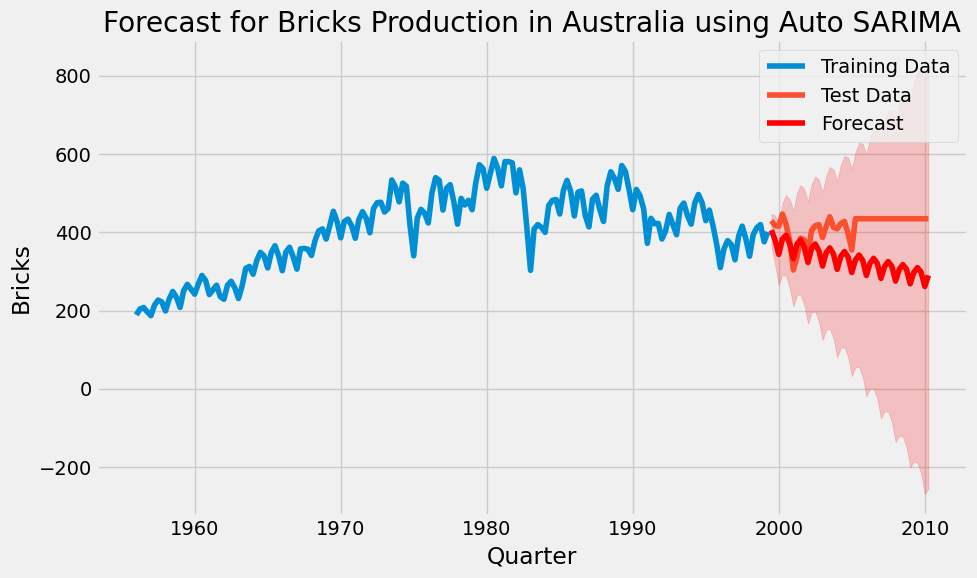

In [72]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index, train[selected_column], label='Training Data')
plt.plot(test.index, test[selected_column], label='Test Data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='r', alpha=0.2)
plt.title(f'Forecast for {selected_column} Production in Australia using Auto SARIMA')
plt.xlabel('Quarter')
plt.ylabel(selected_column)
plt.legend()
plt.tight_layout()
plt.show()

## New South Wales (Australian State) Lamb Population

In [73]:
df = pd.read_csv('aus_livestock.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df = df[df['State'] == 'New South Wales']
df = df[df['Animal'] == 'Lambs']
df

,Month,Animal,State,Count
17088,1972 jul,Lambs,New South Wales,587600.0
17089,1972 ago,Lambs,New South Wales,553700.0
17090,1972 set,Lambs,New South Wales,494900.0
17091,1972 out,Lambs,New South Wales,533500.0
17092,1972 nov,Lambs,New South Wales,574300.0
...,...,...,...,...
17641,2018 ago,Lambs,New South Wales,394300.0
17642,2018 set,Lambs,New South Wales,306900.0
17643,2018 out,Lambs,New South Wales,411200.0
17644,2018 nov,Lambs,New South Wales,426400.0


In [74]:
df.dtypes

Month      object
Animal     object
State      object
Count     float64
dtype: object

In [75]:
# Splitting 'Month' column into 'Year' and 'Month2' columns
df['Year'] = df['Month'].str.split().str[0].astype(int)
df['Month2'] = df['Month'].str.split().str[1]

# Mapping month abbreviations to numeric values
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}
df['Month2'] = df['Month2'].str.lower().map(month_mapping)

# Convert 'Month2' column to integers and handle NaN values
df['Month2'] = df['Month2'].fillna(0).astype(int)

# Filter out zero values from 'Month2'
df = df[df['Month2'] != 0]

In [76]:
# Creating a new 'Date' column with the first day of the corresponding month and year
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month2'].astype(str).str.zfill(2) + '-01')

# Drop the 'Year' and 'Month2' columns if not needed anymore
df.drop(['Year', 'Month2', 'Month'], axis=1, inplace=True)

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_5756\2486067561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month2'].astype(str).str.zfill(2) + '-01')
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_5756\2486067561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Year', 'Month2', 'Month'], axis=1, inplace=True)


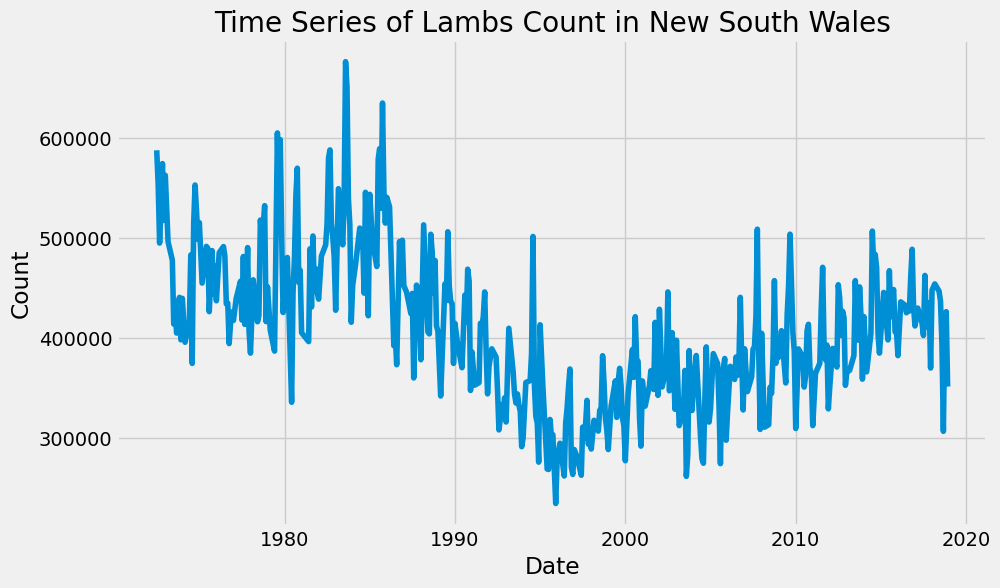

In [79]:
df1 = df.copy()

# Set 'Date' as the index for time series plotting
df1.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df1['Count'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series of Lambs Count in New South Wales')
plt.show()

In [85]:
# Choose 'Count' column for forecasting
selected_column = 'Count'

# Split data into training and test sets
train_size = int(0.8 * len(df))
train, test = df[:train_size], df[train_size:]

# Auto SARIMA Model
model = auto_arima(train[selected_column], seasonal=True, m=12)  # Monthly data
model.fit(train[selected_column])

# Forecast
forecast_steps = len(test)
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[selected_column], forecast))
print(f'RMSE: {rmse}')

RMSE: 38725.57043686449


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


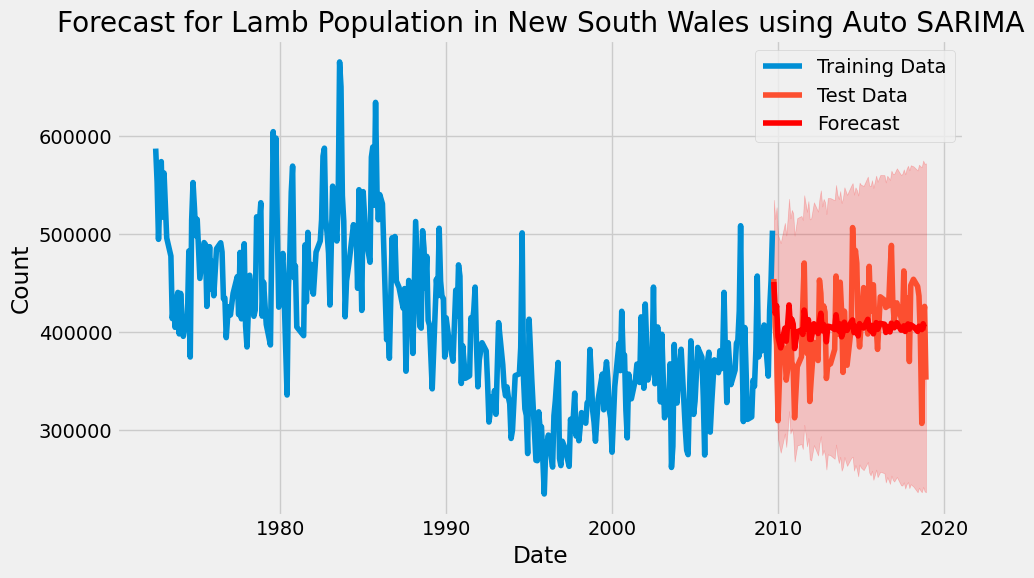

In [86]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index, train[selected_column], label='Training Data')
plt.plot(test.index, test[selected_column], label='Test Data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='r', alpha=0.2)
plt.title(f'Forecast for Lamb Population in New South Wales using Auto SARIMA')
plt.xlabel('Date')
plt.ylabel(selected_column)
plt.legend()
plt.tight_layout()
plt.show()